In [1]:
from moleculekit.molecule import Molecule
import jax_md
import os
from parameters import Parameters, set_box, set_positions
import jax.numpy as nnp
from torchmd.forcefields.forcefield import ForceField
import numpy.linalg as npl
import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
import math
import jax
import scipy

# load alanine dipeptide
testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

2023-06-07 09:04:10,555 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-07 09:04:10,555 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-07 09:04:10,556 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-06-07 09:04:10,556 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [4]:
ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))
parameters = Parameters(ff, mol, precision=float, device='cpu')
nreplicas = 1 # don't change
pos = set_positions(nreplicas, mol.coords)
box = nnp.array(set_box(nreplicas, mol.box), dtype='float32')

from forces import Forces
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])
forces.compute(pos, box)

Calculating the potential should result in the same value, -2190.6, as the original TorchMD code at https://github.com/torchmd/torchmd/blob/master/examples/tutorial.ipynb:

In [82]:
BOLTZMAN = 0.001987191
T = 300

nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)
energy_fn = lambda x : nlogp(x) / (BOLTZMAN * T)
value_grad = jax.value_and_grad(energy_fn)

class MD():


  def __init__(self, d):
    self.d = d
    self.nbrs = None

  def grad_nlogp(self, x):
    return value_grad(x)

  def transform(self, x):
    return x

  def prior_draw(self, key):
    return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


displacement_fn, shift_fn = space.periodic(box[0][0][0].item())
# displacement_fn, shift_fn = space.periodic_general(box[0])

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]


In [101]:
def run_mclmc(dt, L_factor, chain_length, gamma):
    
    fig, axs = plt.subplots(1,2, figsize=(8, 4))
    axs[0].set_xlim(-math.pi, math.pi)
    axs[0].set_ylim(-math.pi, math.pi)
    axs[1].set_xlim(-math.pi, math.pi)
    axs[1].set_ylim(-math.pi, math.pi)
    axs[0].title.set_text('MCLMC')
    axs[1].title.set_text('Langevin')

    eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
    si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
    eps = eps_in_si * si_to_gmol

    target = MD(d = math.prod(pos.shape))
    sampler = Sampler(target, shift_fn=shift_fn, masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = L_factor*eps,
                  eps=eps)
    num_chains = 1
    samples, energy, L, _ = sampler.sample(chain_length, num_chains, output= 'detailed')




    trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory.xyz=nnp.array(nnp.reshape(samples, (samples.shape[0], 688, 3)))[::1]
    unitC = nnp.array([(samples.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
    angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])

    sns.scatterplot(x = angles[:, 0], y = angles[:, 1], ax=axs[0])
    
    # plt.show()

    print("MCLMC\n\n")

    print("L: ", L)
    print("eps: ", eps)

    print("RMS: ", nnp.sqrt(nnp.mean(samples**2, axis=0)).mean())
    print("Energy error: ", (nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape)).mean())

    print("ESS (via ess_corr): ", ess_corr(samples))


    name = 'mclmc' + str(eps) + str(L) + str(num_chains)
    trajectory.save_pdb('./data/prod_alanine_dipeptide_amber/traj'+name+'.pdb')


    ##### LANGEVIN

    key = jax.random.PRNGKey(0)


    dt = dt * 1e-3
    init, update = simulate.nvt_langevin(nlogp, shift_fn, dt, kT=BOLTZMAN*T, gamma=gamma)
    state = init(key, pos)
    samples_langevin = []

    for i in range(chain_length):
        if i%1==0:
            samples_langevin.append(state.position)
        state = update(state)


    trajectory2 = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory2.xyz=nnp.array(nnp.array(samples_langevin).squeeze())[::1]
    unitC = nnp.array([(samples.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory2.unitcell_vectors = unitC
    angles_langevin = md.compute_dihedrals(trajectory2, [phi_indices, psi_indices])
    sns.scatterplot(x = angles_langevin[:, 0], y = angles_langevin[:, 1], ax=axs[1])

    name2 = 'mclmc' + str(dt) + str(gamma) + str(num_chains)
    trajectory2.save_pdb('./data/prod_alanine_dipeptide_amber/traj'+name2+'.pdb')



    print("Langevin\n\n")
    print("Gamma: ", gamma)

    return samples,energy, L, eps, samples_langevin, gamma


MCLMC


L:  43.05105679466853
eps:  1.435035226488951
RMS:  10.142092911781631
Energy error:  0.2844364121593753
ESS (via ess_corr):  0.047118512248111095


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


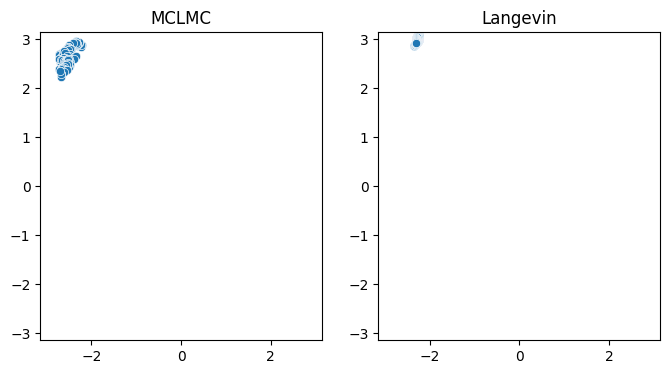

In [102]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=2, L_factor=30, chain_length=100, gamma=0.1)

MCLMC


L:  43.05105679466853
eps:  1.435035226488951
RMS:  10.259763350942515
Energy error:  0.5630788482075761
ESS (via ess_corr):  0.00734516963703379


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


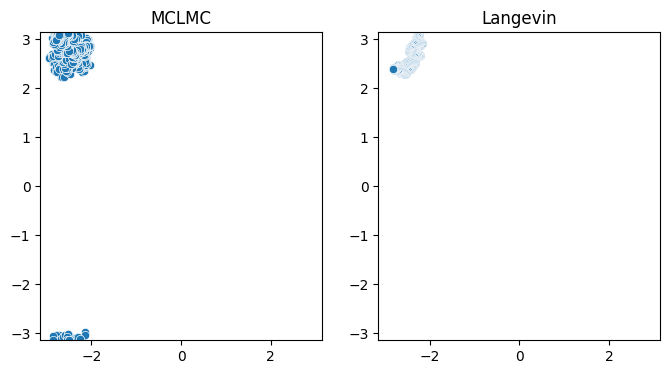

In [103]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=2, L_factor=30, chain_length=1000, gamma=0.1)

In [104]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=2, L_factor=30, chain_length=10000, gamma=0.1)

MCLMC


L:  43.05105679466853
eps:  1.435035226488951
RMS:  10.276860225863517
Energy error:  0.4937610219737243
ESS (via ess_corr):  0.0007664103378610593


MCLMC


L:  21.525528397334266
eps:  0.7175176132444755
RMS:  10.205486528498016
Energy error:  0.09453810991207741


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


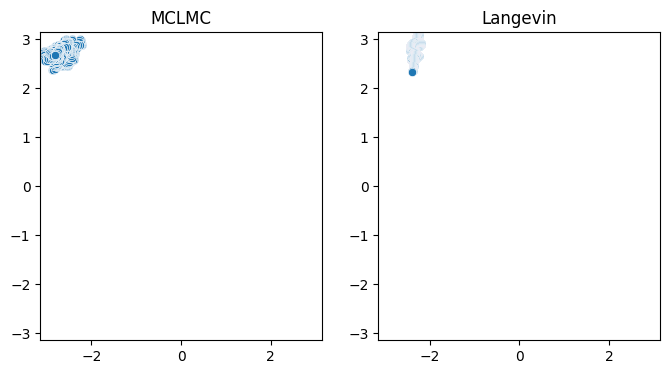

In [ ]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=1, L_factor=30, chain_length=1000, gamma=0.1)

MCLMC


L:  430.5105679466853
eps:  1.435035226488951
RMS:  10.232661731939565
Energy error:  0.6193629831802874


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


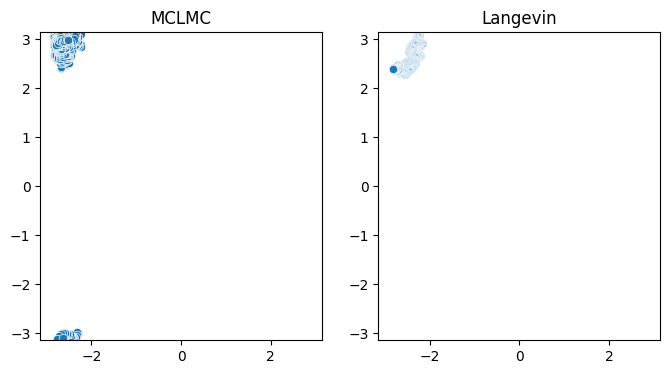

In [ ]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=2, L_factor=300, chain_length=1000, gamma=0.1)

MCLMC


L:  172.20422717867413
eps:  5.740140905955804
RMS:  10.115942419726904
Energy error:  40105.04180094439


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


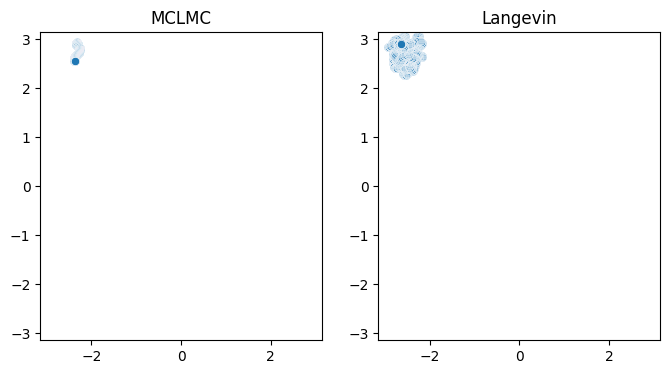

In [ ]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=8, L_factor=30, chain_length=1000, gamma=0.1)

# Dataset for system with more solvent

(-3.141592653589793, 3.141592653589793)

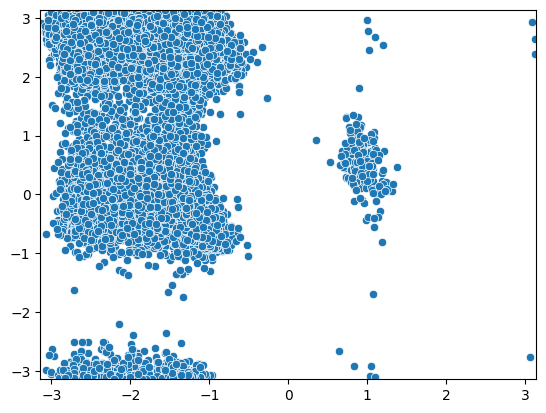

In [ ]:
# traj = md.load('/Users/reubencohn-gordon/Downloads/ala2 2/sim4/trajectory.dcd', top='/Users/reubencohn-gordon/Downloads/ala2 2/ala2.pdb')
# angles3 = md.compute_dihedrals(traj, [phi_indices, psi_indices])
# # # unitC = nnp.array([(len(traj)//100)*[nnp.diag(mol.box[:,0])]]).squeeze()

# sns.scatterplot(x = angles3[::1, 0], y = angles3[::1, 1])
# plt.xlim(-math.pi, math.pi)
# plt.ylim(-math.pi, math.pi)

# # trajectory2.xyz.shape